# Predicciones con algoritmos de regresion

Ahora que vimos un poco sobre el comportamiento de los juegos. Con ciertos parametros que definimos, como:

- Minimo tener 1000 reseñas
- Una secuela se considera exitosa en conparacion a el juego base si esta lo supera en cantidad de reseñas positivas. Y no en el porcentaje total de reseñas positivas

Nos sentraremos en ver como se vincula las secuelas exitosas, con las otras variables que traen. como **precio**, **horas de juego** y otras cosas.
Ademas que tambien repetiremos esto mismo pero haciendo que las secuelas exitosas, se consideran asi, solo si el porcentaje total de reseñas positivas sea mayor a la original.

***

**Cargamos las librerias**

In [15]:
# Librerias a ocupar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import json
import re
import ast
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [8]:
# Abro los csv para despues combinar las columnas que me interesan

with open("data/df_sin_outlier_resenas.csv", "r", encoding="utf-8") as f:
    df_limpio_sin_outlier = pd.read_csv(f)

with open("data/games_march2025_cleaned.csv", "r", encoding="utf-8") as f:
    df_sucio = pd.read_csv(f)

In [9]:
# Lo mismo pero con el df_sucio, pero veo en especifico las columnas
df_sucio.columns

Index(['appid', 'name', 'release_date', 'required_age', 'price', 'dlc_count',
       'detailed_description', 'about_the_game', 'short_description',
       'reviews', 'header_image', 'website', 'support_url', 'support_email',
       'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url',
       'achievements', 'recommendations', 'notes', 'supported_languages',
       'full_audio_languages', 'packages', 'developers', 'publishers',
       'categories', 'genres', 'screenshots', 'movies', 'user_score',
       'score_rank', 'positive', 'negative', 'estimated_owners',
       'average_playtime_forever', 'average_playtime_2weeks',
       'median_playtime_forever', 'median_playtime_2weeks', 'discount',
       'peak_ccu', 'tags', 'pct_pos_total', 'num_reviews_total',
       'pct_pos_recent', 'num_reviews_recent'],
      dtype='object')

***
**Yaque en el analisis de ahora, jusgamos a una secuela en base a cuantas reseñas positiva supero a la original. Agregamos tambien una columna que de boleanos, que indica que si es True, supero a la original y de lo contrario entonces no lo hizo.**

Tambien hago un merge que uno los dos data frame para tener mas columnas a comparar en la regresion. (Esto se puede ir modificando en el transcurso de la investigacion)

In [10]:
# Hago una nueva limpieza para quedarme con las columnas que me interesan, ademas que agrego unas columnas importantes para la regresion

# Me muestra si el juego supero en reseñas a la original
df_limpio_sin_outlier['Supero_original'] = df_limpio_sin_outlier['Reseñas_positivas_Secuela'] >= df_limpio_sin_outlier['Reseñas_positivas_Original']

# Hago que df_sucio solo se quede con las columnas que me interesan
df_sucio = df_sucio[['name', 'price', "dlc_count", "supported_languages","genres", "developers", "publishers",]]

# Uno los dos dataframe con la columna name y Nombre_Original
df_limpio_sin_outlier = pd.merge(df_limpio_sin_outlier, df_sucio, left_on='Nombre_Original', right_on='name', how='left')

In [11]:
df_limpio_sin_outlier.head()

,Nombre_Base,Nombre_Original,Reseñas_positivas_Original,Reseñas_negativas_Original,Nombre_Secuela,Reseñas_positivas_Secuela,Reseñas_negativas_Secuela,Años_de_diferencia,Diferencia_Positivas,Diferencia_Negativas,Supero_original,name,price,dlc_count,supported_languages,genres,developers,publishers
0,12 Labours of Hercules,12 Labours of Hercules,2814,192,12 Labours of Hercules II: The Cretan Bull,1867,208,0,-947,16,False,12 Labours of Hercules,2.99,0,"['English', 'French', 'Japanese', 'Polish', 'R...","['Casual', 'Strategy']","['Jetdogs Studios', 'Zoom Out Games']",['Jetdogs Studios']
1,9-nine-,9-nine-:Episode 1,1461,73,9-nine-:Episode 2,1491,23,0,30,-50,True,9-nine-:Episode 1,19.99,0,"['English', 'Japanese', 'Traditional Chinese']","['Casual', 'Simulation']",['PALETTE'],['Sekai Project']
2,9-nine-,9-nine-:Episode 1,1461,73,9-nine-:Episode 4,1089,20,2,-372,-53,False,9-nine-:Episode 1,19.99,0,"['English', 'Japanese', 'Traditional Chinese']","['Casual', 'Simulation']",['PALETTE'],['Sekai Project']
3,A Plague Tale,A Plague Tale: Innocence,58010,4066,A Plague Tale: Requiem,17807,1721,3,-40203,-2345,False,A Plague Tale: Innocence,7.99,1,"['English', 'French', 'Italian', 'German', 'Sp...","['Action', 'Adventure']",['Asobo Studio'],['Focus Entertainment']
4,A Total War Saga,A Total War Saga: THRONES OF BRITANNIA,9829,4191,A Total War Saga: TROY,2303,914,3,-7526,-3277,False,A Total War Saga: THRONES OF BRITANNIA,39.99,1,"['English', 'French', 'Italian', 'German', 'Sp...","['Action', 'Strategy']","['CREATIVE ASSEMBLY', 'Feral Interactive (Mac)...","['SEGA', 'Feral Interactive (Mac)', 'Feral Int..."


In [12]:
# Guardo este data frame temporalmente
with open("data/df_regresion_completo.csv", "w", encoding="utf-8") as f:
    df_limpio_sin_outlier.to_csv(f, index=False)

***
## Empiezo a ver los posibles recursos de regresion que puedo ocupar con este data frame y sus columans

Precisión del modelo: 65.22%


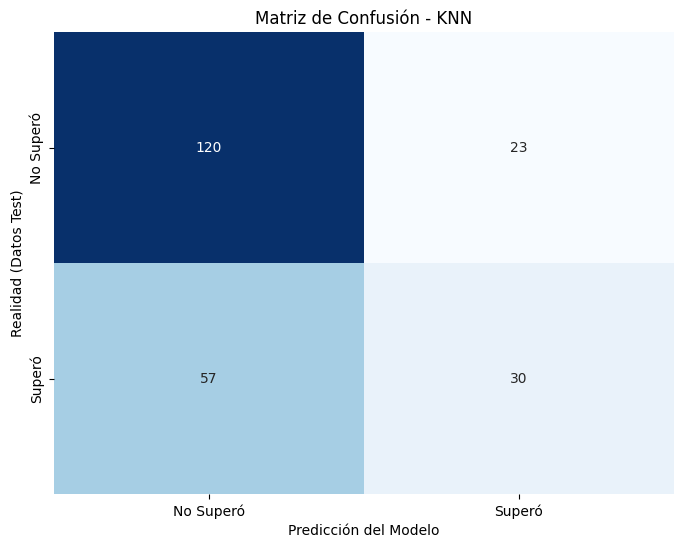

In [14]:
df = pd.read_csv('data/df_regresion_completo.csv')

# Variable Objetivo (Y): Convertimos True/False a 1/0
y = df['Supero_original'].astype(int)

# Función auxiliar para procesar columnas que contienen listas como texto
# Ej: "['Action', 'Adventure']" -> Columna_Action: 1, Columna_Adventure: 1
def procesar_columna_lista(df, nombre_col, top_n=None):
    # Convertir string a lista de Python real
    lista_limpia = df[nombre_col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    
    # Obtener lista plana de todos los items para contar frecuencias
    todos_items = [item for sublist in lista_limpia for item in sublist]
    
    # Seleccionar cuáles usaremos (Top N más frecuentes o todos)
    if top_n:
        top_items = [item for item, count in Counter(todos_items).most_common(top_n)]
    else:
        top_items = sorted(list(set(todos_items)))
    
    # Crear un DataFrame dummy (One-Hot Encoding manual)
    datos_dummy = pd.DataFrame()
    for item in top_items:
        # Limpiar nombre para evitar caracteres raros en columnas
        nombre_limpio = f"{nombre_col}_{item.replace(' ', '_').replace('-', '_')}"
        datos_dummy[nombre_limpio] = lista_limpia.apply(lambda x: 1 if item in x else 0)
    
    return datos_dummy

# Aplicar la función a las columnas categóricas
X_genres = procesar_columna_lista(df, 'genres', top_n=None)        # Todos los géneros
X_langs  = procesar_columna_lista(df, 'supported_languages', top_n=15) # Top 15 idiomas
X_devs   = procesar_columna_lista(df, 'developers', top_n=10)      # Top 10 devs (evita ruido)
X_pubs   = procesar_columna_lista(df, 'publishers', top_n=10)      # Top 10 publishers

# Variables numéricas base
X_base = df[['Años_de_diferencia', 'price', 'dlc_count']]

# Unir todo en la matriz final X
X = pd.concat([X_base, X_genres, X_langs, X_devs, X_pubs], axis=1)

# ---------------------------------------------------------
# 2. ESCALADO Y DIVISIÓN (Train/Test)
# ---------------------------------------------------------
# Estandarizar datos (Vital para KNN porque se basa en distancias)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir 70% entrenamiento - 30% testeo
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42
)

# ---------------------------------------------------------
# 3. MODELADO (KNeighborsClassifier)
# ---------------------------------------------------------
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Realizar predicciones
y_pred = knn.predict(X_test)

# Imprimir precisión simple
print(f"Precisión del modelo: {accuracy_score(y_test, y_pred):.2%}")

# ---------------------------------------------------------
# 4. GRAFICAR MATRIZ DE CONFUSIÓN
# ---------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Superó', 'Superó'],
            yticklabels=['No Superó', 'Superó'])

plt.xlabel('Predicción del Modelo')
plt.ylabel('Realidad (Datos Test)')
plt.title('Matriz de Confusión - KNN')
plt.show() # Muestra el gráfico si corres esto en local

In [21]:

# 1. Usamos las mismas variables X e y que ya tenías
# (Asegúrate de tener X con las columnas dummy creadas)

# 2. Entrenar Random Forest (Es excelente descubriendo patrones ocultos)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# 3. Extraer la importancia de cada variable
importancia = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

importancia.head(10)

,Variable,Importancia
0,Años_de_diferencia,0.234239
1,price,0.134384
2,dlc_count,0.076590
9,genres_Indie,0.032827
3,genres_Action,0.031342
12,genres_RPG,0.030870
4,genres_Adventure,0.029090
15,genres_Simulation,0.028025
17,genres_Strategy,0.028018
26,supported_languages_Simplified_Chinese,0.026410


C:\Users\reyes\AppData\Local\Temp\ipykernel_27680\3223836491.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


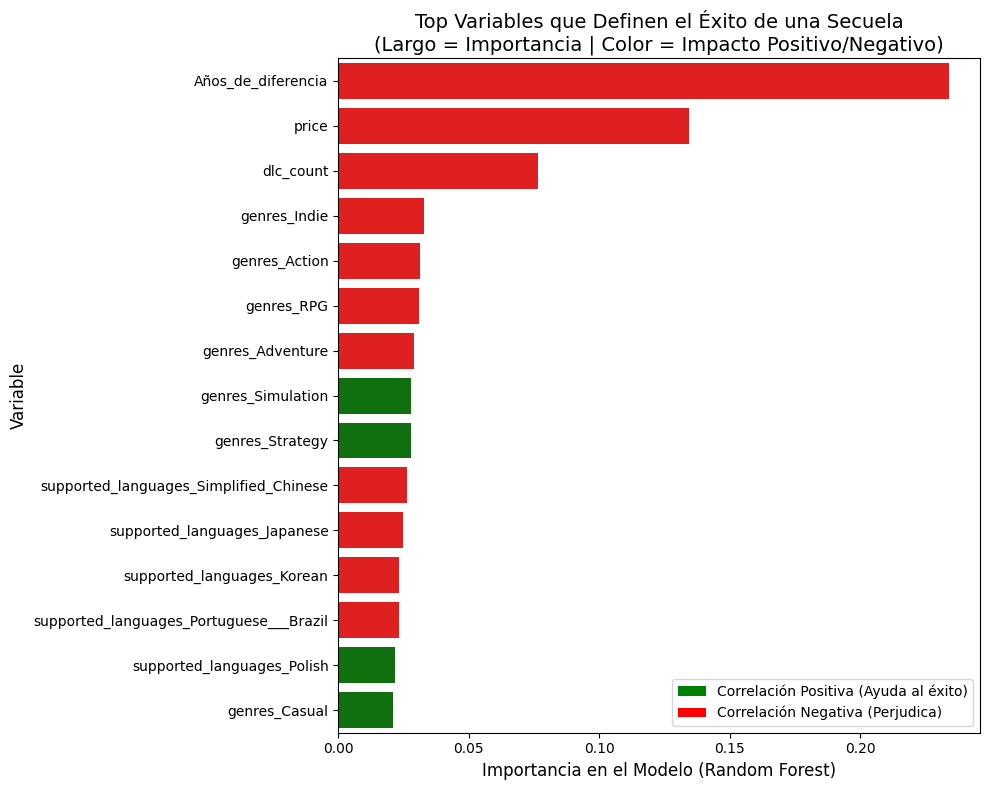

In [23]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

# ---------------------------------------------------------
# 1. CARGA Y PREPROCESAMIENTO (Igual que antes)
# ---------------------------------------------------------
df = pd.read_csv('data/df_regresion_completo.csv')
y = df['Supero_original'].astype(int)

def procesar_columna_lista(df, nombre_col, top_n=None):
    lista_limpia = df[nombre_col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    todos_items = [item for sublist in lista_limpia for item in sublist]
    if top_n:
        top_items = [item for item, count in Counter(todos_items).most_common(top_n)]
    else:
        top_items = sorted(list(set(todos_items)))
    datos_dummy = pd.DataFrame()
    for item in top_items:
        nombre_limpio = f"{nombre_col}_{item.replace(' ', '_').replace('-', '_')}"
        datos_dummy[nombre_limpio] = lista_limpia.apply(lambda x: 1 if item in x else 0)
    return datos_dummy

# Generar variables X
X_genres = procesar_columna_lista(df, 'genres', top_n=None)
X_langs  = procesar_columna_lista(df, 'supported_languages', top_n=15)
X_devs   = procesar_columna_lista(df, 'developers', top_n=10)
X_pubs   = procesar_columna_lista(df, 'publishers', top_n=10)
X_base   = df[['Años_de_diferencia', 'price', 'dlc_count']]

X = pd.concat([X_base, X_genres, X_langs, X_devs, X_pubs], axis=1)

# ---------------------------------------------------------
# 2. OBTENER DATOS PARA EL GRÁFICO
# ---------------------------------------------------------

# A) Calcular IMPORTANCIA (Random Forest) - Define el largo de la barra
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importancias = rf.feature_importances_

# B) Calcular CORRELACIÓN - Define el color (Positivo/Negativo)
# Creamos un DF temporal uniendo X con la Y para calcular correlación
df_temp = X.copy()
df_temp['OBJETIVO'] = y
correlaciones = df_temp.corr()['OBJETIVO'].drop('OBJETIVO')

# ---------------------------------------------------------
# 3. ARMAR LA TABLA FINAL
# ---------------------------------------------------------
df_grafico = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': importancias,
    'Correlacion': [correlaciones[col] for col in X.columns] # Buscamos la corr de cada variable
})

# Ordenar por importancia (las más grandes primero) y tomar el Top 15
df_grafico = df_grafico.sort_values(by='Importancia', ascending=False).head(15)

# Crear columna de color basada en el signo de la correlación
# Si correlación > 0 -> 'green' (Ayuda), si no -> 'red' (Perjudica)
df_grafico['Color'] = df_grafico['Correlacion'].apply(lambda x: 'green' if x > 0 else 'red')

# ---------------------------------------------------------
# 4. GRAFICAR
# ---------------------------------------------------------
plt.figure(figsize=(10, 8))

# Usamos barplot, pasando la columna 'Color' al parámetro palette
# Nota: Para que 'palette' funcione con una lista directa de colores, a veces es mejor iterar,
# pero aquí usaremos un truco simple pasando los colores directamente al gráfico.
barplot = sns.barplot(
    x='Importancia', 
    y='Variable', 
    data=df_grafico, 
    palette=df_grafico['Color'].tolist() # Pasamos la lista exacta de colores
)

# Añadir etiquetas y títulos
plt.title('Top Variables que Definen el Éxito de una Secuela\n(Largo = Importancia | Color = Impacto Positivo/Negativo)', fontsize=14)
plt.xlabel('Importancia en el Modelo (Random Forest)', fontsize=12)
plt.ylabel('Variable', fontsize=12)

# Añadir leyenda manual (truco visual)
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Correlación Positiva (Ayuda al éxito)'),
    Patch(facecolor='red', label='Correlación Negativa (Perjudica)')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()